# Sentimental Analysis on Amazon Reviews

### Importing required libraries

In [77]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import neattext.functions as nfx
from wordcloud import WordCloud
import nltk
from nltk.stem.porter import PorterStemmer
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [55]:
%pip install wordcloud

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/f5/b0/247159f61c5d5d6647171bef84430b7efad4db504f0229674024f3a4f7f2/wordcloud-1.9.3-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/300.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/300.2 kB ? eta -:--:--
   --- ----------------------------------- 30.7/300.2 kB 445.2 kB/s eta 0:00:01
   ------- ------------------------------- 61.4/300.2 kB 469.7 kB/s eta 0:00:01
   -------------- ----------------------- 112.6/300.2 kB 656.4 kB/s eta 0:00:01
   ---------------------- --------------- 174.1/300.2 kB 807.1 kB/s eta 0:00:01
   ---------------------------- --------- 225.3/300.2 kB 919.0 kB/s eta 0:00:01
   ---------------------------------------- 300.2/300.2 kB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Reading datasets
data = pd.read_csv(r"amazon_alexa.tsv",delimiter='\t', quoting=3)
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [6]:
data.tail()

,rating,date,variation,verified_reviews,feedback
3145,5,30-Jul-18,Black Dot,"""Perfect for kids, adults and everyone in betw...",1
3146,5,30-Jul-18,Black Dot,"""Listening to music, searching locations, chec...",1
3147,5,30-Jul-18,Black Dot,"""I do love these things, i have them running m...",1
3148,5,30-Jul-18,White Dot,"""Only complaint I have is that the sound quali...",1
3149,4,29-Jul-18,Black Dot,Good,1


In [5]:
data.shape

(3150, 5)

In [7]:
#columms names
data.columns.values

array(['rating', 'date', 'variation', 'verified_reviews', 'feedback'],
      dtype=object)

In [9]:
data.isna().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [10]:
data[data['verified_reviews'].isna()==True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [11]:
data.dropna(inplace=True)

In [12]:
data.shape

(3149, 5)

In [13]:
data['length']= data['verified_reviews'].apply(len)

In [15]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [16]:
#Randomly checking for 10th record

print(f"'verified_reviews' column value: {data.iloc[10]['verified_reviews']}") #Original value
print(f"Length of review : {len(data.iloc[10]['verified_reviews'])}") #Length of review using len()
print(f"'length' column value : {data.iloc[10]['length']}") #Value of the column 'length'

'verified_reviews' column value: "I sent it to my 85 year old Dad, and he talks to it constantly."
Length of review : 65
'length' column value : 65


In [17]:
# checking the datatypes
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

``` Analyzing the rating columns```

In [18]:

data["rating"].value_counts()

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

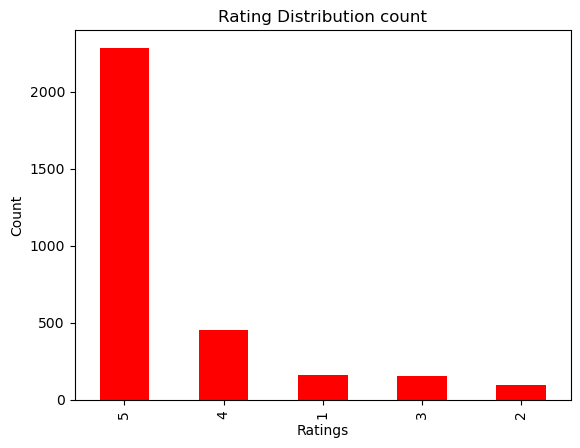

In [19]:
# bar plot for the rating 
data['rating'].value_counts().plot.bar(color='red')
plt.title('Rating Distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [20]:
#Finding the percentage distribution of each rating - we'll divide the number of records for each rating by total number of records

print(f"Rating value count - percentage distribution: \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: 
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


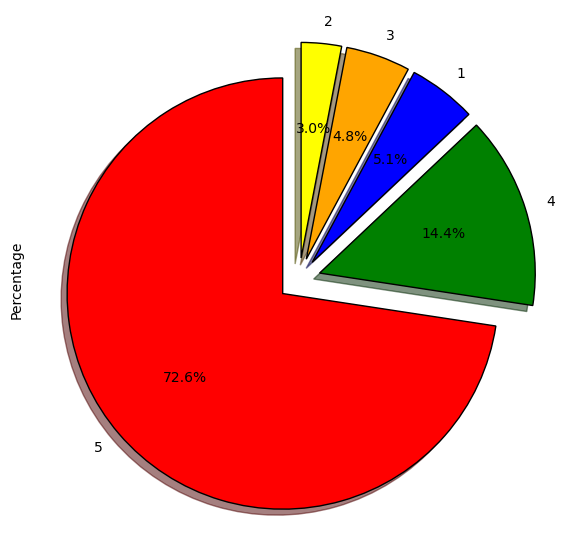

In [27]:
fig = plt.figure(figsize=(7,7))
colors = ('red','green','blue','orange','yellow')
wp = {'linewidth':1, 'edgecolor':'black'}
tags = data['rating'].value_counts()/data.shape[0]
explode =(0.1, 0.1, 0.1,0.1,0.1)
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp,explode=explode, label = 'Percentage')
from io import BytesIO
graphs = BytesIO()

'``Analyzing feedback columnm``'

In [28]:
data['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

There are 2 distinct value of feedback 0 and 1. let's see what does this represemt

In [30]:
#extracting verified reviews for one record with feedback = 0
review_0= data[data['feedback']==0].iloc[1]['verified_reviews']
review_0

'Sound is terrible if u want good music too get a bose'

In [31]:
#extracting verified reviews for one record with feedback = 1
review_1= data[data['feedback']==1].iloc[1]['verified_reviews']
review_1

'Loved it!'

`From above review_0 and review_1 we know the feedback 0 is negative review and 1 is positive review`

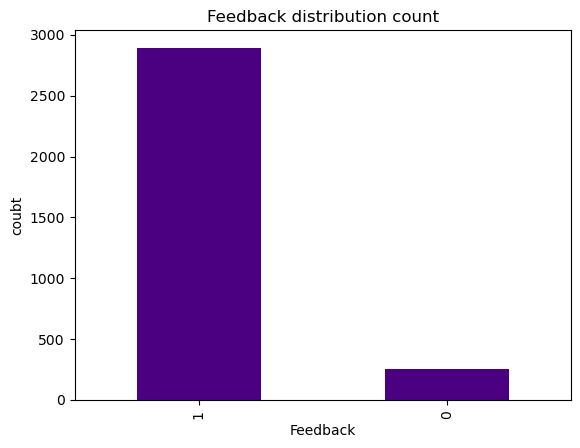

In [34]:
#lets plot the graph for the total counts of each feedback
data['feedback'].value_counts().plot.bar(color='indigo')
plt.title("Feedback distribution count")
plt.xlabel("Feedback")
plt.ylabel("coubt")
plt.show()

In [35]:
print(f"Feeback value count - Percentage value distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feeback value count - Percentage value distribution: 
feedback
1    91.87
0     8.13
Name: count, dtype: float64


<Axes: ylabel='Percentage wise distrubution of feedback'>

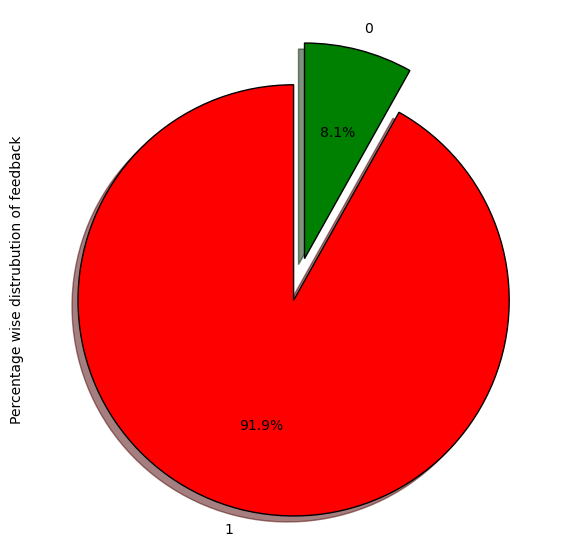

In [44]:
fig = plt.figure(figsize=(7,7))
colors = ('red', 'green')
wp = {'linewidth':1, "edgecolor":'black'}
tags = data['feedback'].value_counts()/data.shape[0]
explode=(0.1,0.1)
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

`Lets Analyze the rating values for different values of feedback`

In [37]:
#feedback =0 
data[data['feedback']==0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [38]:
#feedback =1
data[data['feedback']==1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

Then we came to conclusion that feedback with 0 and having rating 1 and 2 are Negative review 
Feeback with 1 and having rating of 5 4 and 3 are Positive review

`Analyzing the variation`

In [39]:
data['variation'].value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

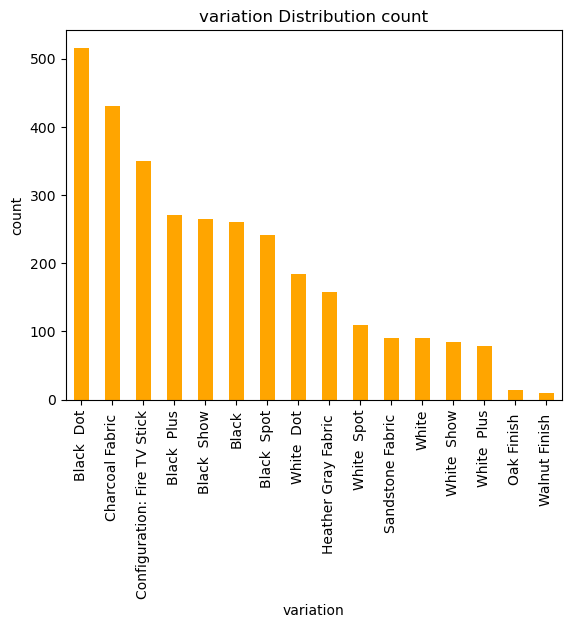

In [40]:
data['variation'].value_counts().plot.bar(color='orange')
plt.title('variation Distribution count')
plt.xlabel('variation')
plt.ylabel('count')
plt.show()

In [41]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

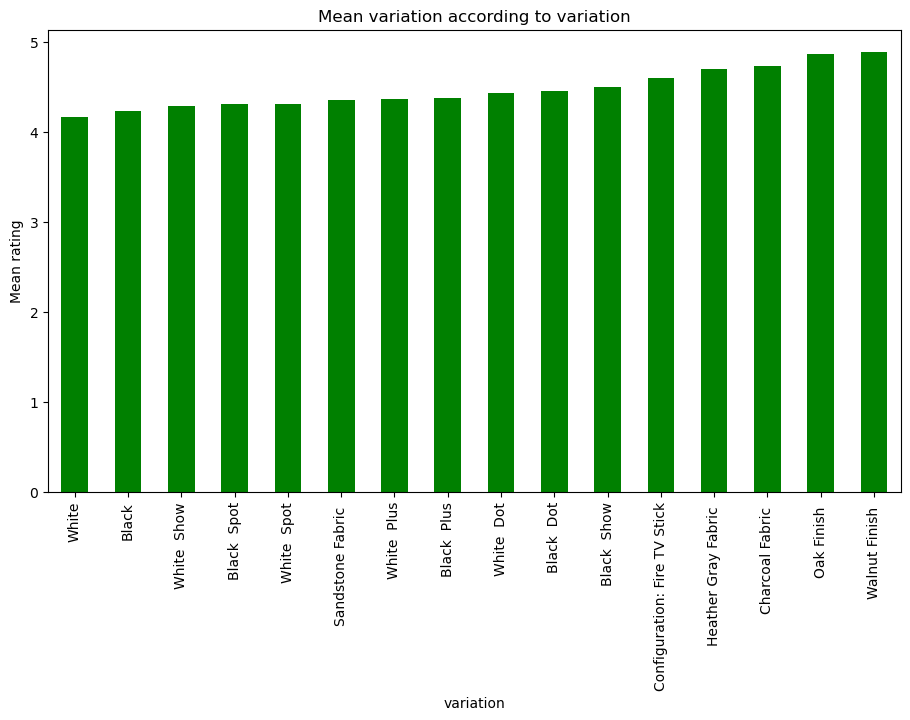

In [43]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color='green',figsize=(11,6))
plt.title("Mean variation according to variation")
plt.xlabel('variation')
plt.ylabel('Mean rating')
plt.show()

`Analyzing verified_reviews Column`

In [45]:
data['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

c:\Users\Acer\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


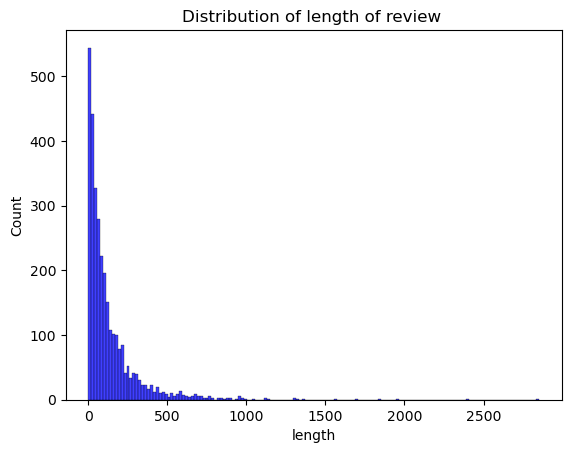

In [47]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')
plt.show()

c:\Users\Acer\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

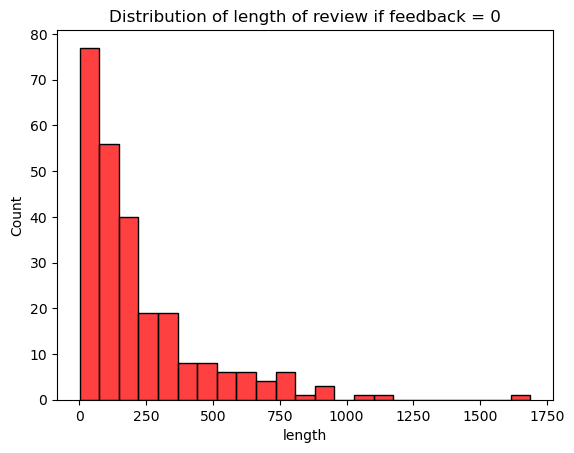

In [48]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

c:\Users\Acer\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

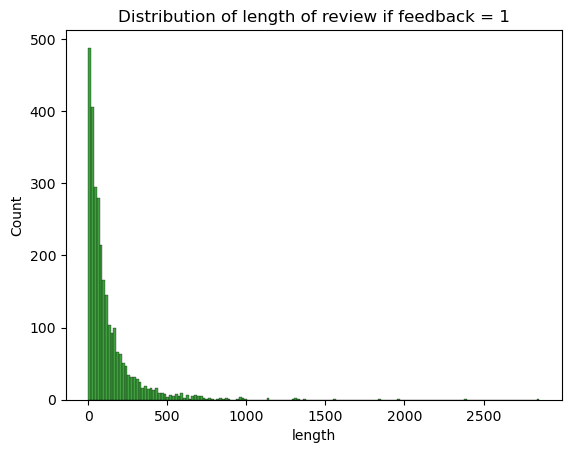

In [49]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

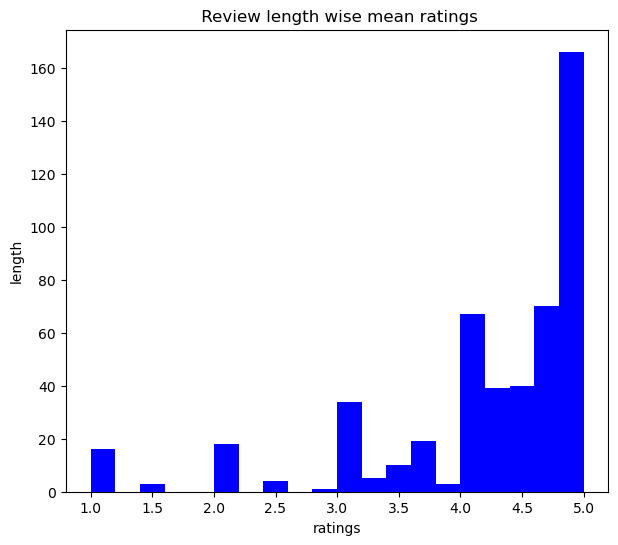

In [50]:

data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [52]:
data['Clean_verified_reviews'] = data['verified_reviews'].apply(nfx.remove_stopwords)

In [53]:
data.head()

,rating,date,variation,verified_reviews,feedback,length,Clean_verified_reviews
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13,Love Echo!
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9,Loved it!
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197,"""Sometimes playing game, answer question corre..."
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174,"""I lot fun thing. 4 yr old learns dinosaurs, c..."
4,5,31-Jul-18,Charcoal Fabric,Music,1,5,Music


In [54]:
cv = CountVectorizer()
words = cv.fit_transform(data.Clean_verified_reviews)

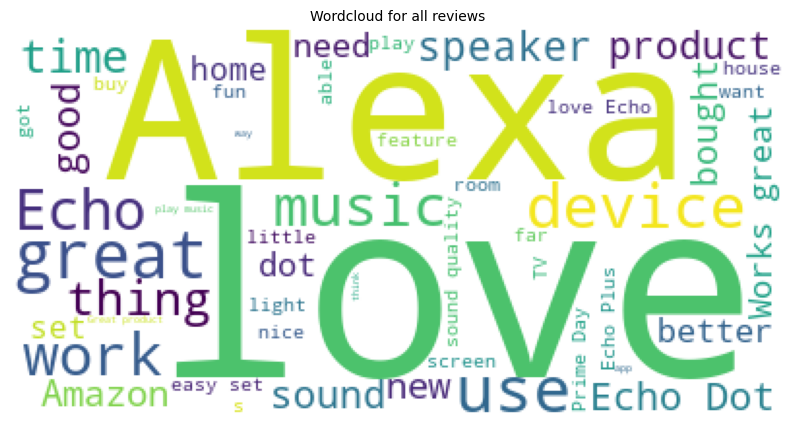

In [57]:
# Combine all reviews
reviews = " ".join([review for review in data['Clean_verified_reviews']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [58]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['Clean_verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['Clean_verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

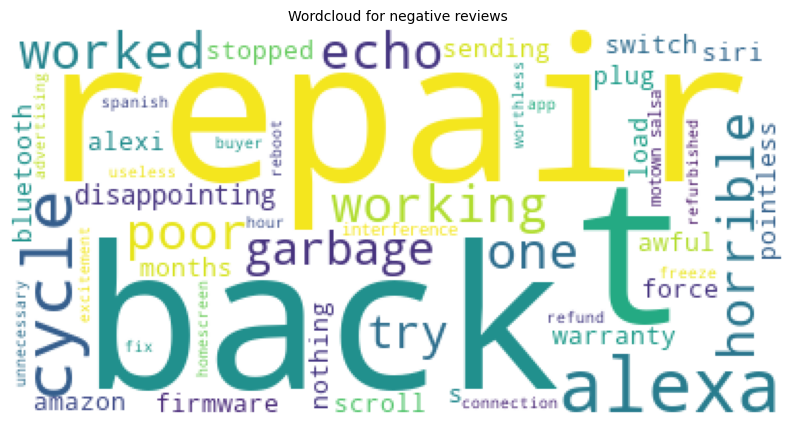

In [59]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

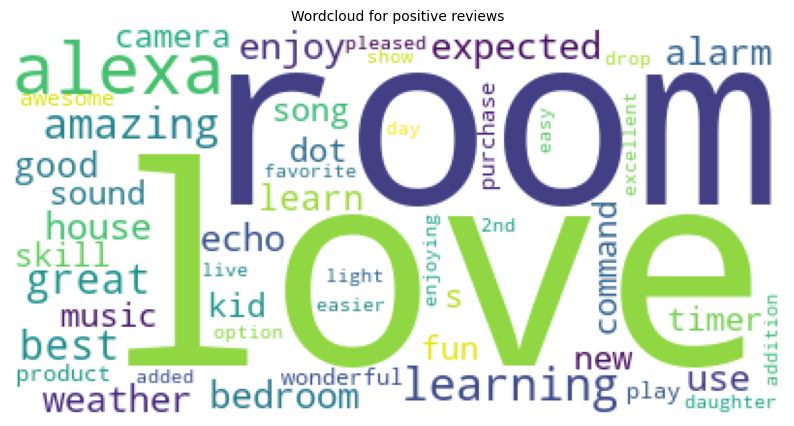

In [60]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

In [68]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['Clean_verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review]
  review = ' '.join(review)
  corpus.append(review)

In [69]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [70]:
import pickle
#Saving the Count Vectorizer
pickle.dump(cv, open('countVectorizer.pkl', 'wb'))

In [71]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3149, 2500)
y shape: (3149,)


In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2204, 2500)
y train: (2204,)
X test: (945, 2500)
y test: (945,)


In [74]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 10


In [75]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [76]:
pickle.dump(scaler, open('scaler.pkl', 'wb'))

`Random Forest`

In [78]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [79]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9950090744101633
Testing Accuracy : 0.9428571428571428


In [80]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

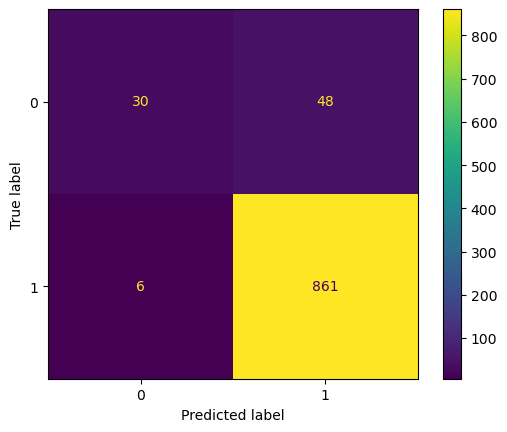

In [81]:
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

`K flod cross validation`

In [82]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9328506787330315
Standard Variance : 0.00902799630953904


`Appling the gird search `

In [83]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}


In [84]:

cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [85]:
print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 80, 'min_samples_split': 12, 'n_estimators': 100}


In [86]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 96.89768602540835
Cross validation mean accuracy on test set : 92.26973684210526
Accuracy score for test set : 0.9428571428571428


`XGboost`

In [87]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [88]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.9732304900181489
Testing Accuracy : 0.9375661375661376


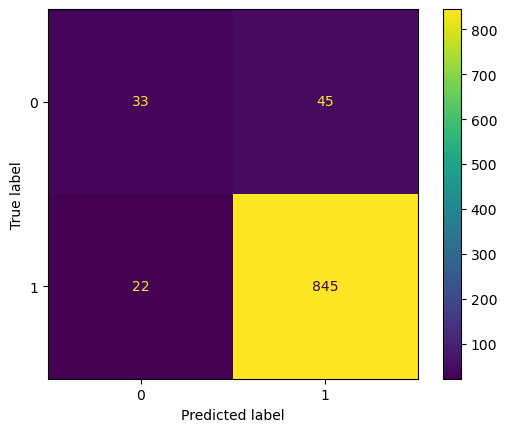

In [89]:
y_preds = model_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [90]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('model_xgb.pkl', 'wb'))

'DecisionTreeClassifier'

In [91]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [92]:
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))


Training Accuracy : 0.9950090744101633
Testing Accuracy : 0.908994708994709


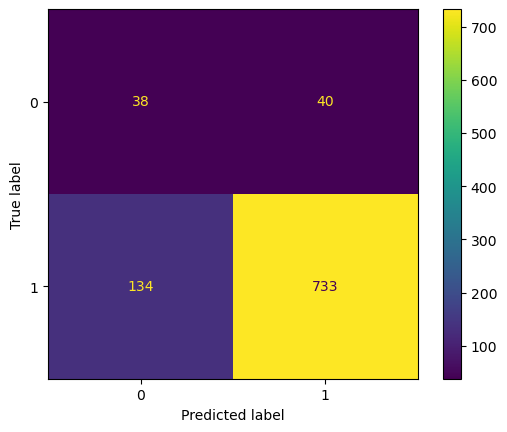

In [95]:
#Confusion Matrix
y_preds = model_dt.predict(X_test)
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()
